#### Hybrid PCA-Autoencoder-CNN model for portfolio optimization, integrating PCA initialization with autoencoder training and CNN prediction:


The purpose of this hybrid PCA–autoencoder–CNN approach is to leverage the strengths of both linear and non-linear dimensionality reduction techniques in order to extract the most informative features from high-dimensional financial data before portfolio optimization. First, Principal Component Analysis (PCA) is used to reduce noise and compress the data by capturing the most significant linear relationships, which helps mitigate the curse of dimensionality and improves interpretability. Next, an autoencoder further refines this representation by learning non-linear patterns and hierarchical features that PCA cannot capture, resulting in more robust and informative latent factors. These compressed features are then used as input to a convolutional neural network (CNN), which learns to construct optimal portfolio weights based on the extracted factors. This integrated pipeline aims to improve model performance, reduce overfitting, and enhance the ability to uncover complex relationships in financial markets, ultimately supporting more effective and adaptive portfolio optimization.

Related
What is the main goal of using autoencoders in data compression and noise reduction
How do autoencoders help in capturing essential features from complex data
Why are regularization techniques like contractive autoencoders important for model robustness
In what ways do denoising autoencoders improve data quality for machine learning tasks
How does understanding the purpose of autoencoders enhance their application in various fields


- Loading the dataset

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os
import psutil

# --- Memory tracking functions ---
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 ** 3)  # in GB

def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
    return 0

# --- Timer context manager ---
class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self
    
    def __exit__(self, *args):
        self.end_time = time.time()
        self.duration = self.end_time - self.start_time

# --- Data Loading and Preprocessing ---
print("Starting data loading...")
data_load_start = time.time()

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features = ['returns','RSI_14','Volatility_21','MACD','ADX_14','umich_consumer_sentiment','new_home_sales','housing_starts']  
lookback = 20

# Create sequences and targets
X_list, y_list, dates_list = [], [], []
all_dates = sorted(data['Date'].unique())

for i in range(lookback, len(data)):
    cur_date = data.iloc[i]['Date']
    day_slice = data[data['Date'] == cur_date]
    if set(assets) <= set(day_slice['Ticker']):
        X_i = []
        valid = True
        for asset in assets:
            asset_slice = data[(data['Ticker'] == asset) & (data['Date'] <= cur_date)].tail(lookback)
            if len(asset_slice) == lookback:
                X_i.append(asset_slice[features].values)
            else:
                valid = False
                break
        if valid:
            # Get next day returns
            cur_idx = all_dates.index(cur_date)
            if cur_idx + 1 < len(all_dates):
                next_date = all_dates[cur_idx + 1]
                next_returns = []
                for asset in assets:
                    next_row = data[(data['Date'] == next_date) & (data['Ticker'] == asset)]
                    if not next_row.empty:
                        next_returns.append(next_row['returns'].values[0])
                    else:
                        valid = False
                        break
                if valid:
                    X_i = np.stack(X_i, axis=1)  # (lookback, n_assets, n_features)
                    X_list.append(X_i)
                    y_list.append(next_returns)
                    dates_list.append(cur_date)

X = np.array(X_list)  # (samples, lookback, n_assets, n_features)
y = np.array(y_list)
dates = np.array(dates_list)

data_load_time = time.time() - data_load_start
print(f"Data loaded in {data_load_time:.2f} seconds, shape: {X.shape}")

# --- Hybrid Dimensionality Reduction: PCA + Autoencoder ---
print("\nStarting dimensionality reduction...")
dim_red_start = time.time()

# Reshape and standardize
samples, lb, n_assets, n_features = X.shape
X_flat = X.reshape(-1, n_features)

with Timer() as t_scaler:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
scaler_time = t_scaler.duration

# Apply PCA
with Timer() as t_pca:
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    pca_dims = X_pca.shape[1]
pca_time = t_pca.duration
print(f"PCA reduced dimensions to {pca_dims} in {pca_time:.2f}s")

# Autoencoder on PCA output
class PCAEnhancedAE(nn.Module):
    def __init__(self, input_dim, latent_dim=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

# Initialize and train autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae_model = PCAEnhancedAE(pca_dims, latent_dim=6).to(device)
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_pca_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)

# Autoencoder training
print("Training autoencoder...")
ae_train_start = time.time()
ae_losses = []
for epoch in range(50):
    epoch_start = time.time()
    optimizer.zero_grad()
    recon, latent = ae_model(X_pca_tensor)
    loss = criterion(recon, X_pca_tensor)
    loss.backward()
    optimizer.step()
    ae_losses.append(loss.item())
    
    if epoch % 10 == 0:
        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch}: Loss={loss.item():.6f}, Time={epoch_time:.2f}s')

ae_train_time = time.time() - ae_train_start
print(f"Autoencoder trained in {ae_train_time:.2f} seconds")

# Extract latent representations
ae_model.eval()
with torch.no_grad():
    _, latent_vectors = ae_model(X_pca_tensor)
    latent_vectors = latent_vectors.cpu().numpy()

# Reshape for CNN input
latent_reshaped = latent_vectors.reshape(samples, lb, n_assets, -1)
X_cnn = latent_reshaped.reshape(samples, lb, n_assets * latent_reshaped.shape[-1])

dim_red_time = time.time() - dim_red_start
print(f"Dimensionality reduction completed in {dim_red_time:.2f} seconds")
print(f"Final CNN input shape: {X_cnn.shape}")

# --- CNN Model Definition ---
class PortfolioCNN(nn.Module):
    def __init__(self, input_channels, lookback, n_assets, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
        with torch.no_grad():
            self.flattened_size = self.conv(torch.zeros(1, 1, lookback, n_assets * latent_dim)).numel()
        
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, n_assets)
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.softmax(x, dim=1)

# --- Training Setup ---
print("\nPreparing CNN training...")
X_tensor = torch.tensor(X_cnn, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Train/test split
split_idx = int(0.7 * len(X_tensor))
X_train, X_test = X_tensor[:split_idx], X_tensor[split_idx:]
y_train, y_test = y_tensor[:split_idx], y_tensor[split_idx:]
train_dates, test_dates = dates[:split_idx], dates[split_idx:]

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# Initialize CNN
n_assets = len(assets)
latent_dim = latent_reshaped.shape[-1]
cnn_model = PortfolioCNN(1, lookback, n_assets, latent_dim)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# --- Portfolio Evaluation Functions ---
def sharpe_loss(portfolio_returns):
    return -torch.mean(portfolio_returns) / (torch.std(portfolio_returns) + 1e-6)

def evaluate_portfolio(model, X, y, dates, cost_rate=0.0005):
    model.eval()
    portfolio_values = [1.0]
    weights_history = []
    returns = []
    prev_weights = None
    
    with torch.no_grad():
        for i in range(len(X)):
            current_X = X[i].unsqueeze(0)
            current_y = y[i]
            weights = model(current_X)
            raw_return = torch.sum(weights * current_y).item()
            
            if prev_weights is not None:
                turnover = torch.sum(torch.abs(weights - prev_weights)).item()
                raw_return -= cost_rate * turnover
            
            portfolio_values.append(portfolio_values[-1] * (1 + raw_return))
            weights_history.append(weights.squeeze().cpu().numpy())
            returns.append(raw_return)
            prev_weights = weights.clone()
    
    returns = np.array(returns)
    portfolio_values = np.array(portfolio_values)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-9)
    
    # Calculate max drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = np.max(drawdown)
    
    # Annualized metrics
    ann_return = (portfolio_values[-1] / portfolio_values[0]) ** (252 / len(returns)) - 1
    ann_vol = np.std(returns) * np.sqrt(252)
    
    return {
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'cumulative_returns': portfolio_values,
        'weights': np.array(weights_history),
        'dates': dates
    }

# --- Training Loop ---
print("\nTraining CNN model...")
cnn_train_start = time.time()
sharpe_ratios = []
for epoch in range(50):
    epoch_start = time.time()
    optimizer.zero_grad()
    weights = cnn_model(X_train)
    portfolio_returns = torch.sum(weights * y_train, dim=1)
    loss = sharpe_loss(portfolio_returns)
    loss.backward()
    optimizer.step()
    
    # Record training Sharpe ratio
    with torch.no_grad():
        train_sharpe = -loss.item()
        sharpe_ratios.append(train_sharpe)
    
    epoch_time = time.time() - epoch_start
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Sharpe={train_sharpe:.4f}, Time={epoch_time:.2f}s')

cnn_train_time = time.time() - cnn_train_start
print(f"CNN trained in {cnn_train_time:.2f} seconds")

# --- Evaluation ---
print("\nEvaluating portfolio performance...")
eval_start = time.time()

# Evaluate on train and test sets
train_results = evaluate_portfolio(cnn_model, X_train, y_train, train_dates)
test_results = evaluate_portfolio(cnn_model, X_test, y_test, test_dates)

eval_time = time.time() - eval_start
print(f"Evaluation completed in {eval_time:.2f} seconds")

# --- Performance Metrics Report ---
print("\n" + "="*60)
print("Performance Metrics Report")
print("="*60)

# Resource Utilization
print("\nResource Utilization:")
print(f"- Data loading time: {data_load_time:.2f}s")
print(f"- Scaling time: {scaler_time:.2f}s")
print(f"- PCA time: {pca_time:.2f}s")
print(f"- Autoencoder training time: {ae_train_time:.2f}s")
print(f"- CNN training time: {cnn_train_time:.2f}s")
print(f"- Evaluation time: {eval_time:.2f}s")

if torch.cuda.is_available():
    print(f"- GPU memory used: {get_gpu_memory():.2f} GB")
print(f"- RAM usage: {get_memory_usage():.2f} GB")

# Autoencoder Performance
print("\nAutoencoder Performance:")
print(f"- Final training loss (MSE): {ae_losses[-1]:.6f}")
print(f"- Latent dimension: {latent_dim}")
print(f"- Parameters: {sum(p.numel() for p in ae_model.parameters()):,}")

# Portfolio Performance
def print_portfolio_metrics(name, results):
    print(f"\n{name} Portfolio Performance:")
    print(f"- Sharpe Ratio: {results['sharpe']:.2f}")
    print(f"- Annualized Return: {results['annualized_return']:.2%}")
    print(f"- Annualized Volatility: {results['annualized_vol']:.2%}")
    print(f"- Maximum Drawdown: {results['max_drawdown']:.2%}")

print_portfolio_metrics("Training", train_results)
print_portfolio_metrics("Test", test_results)

print("\n" + "="*60)

# --- Save Results ---
results_df = pd.DataFrame({
    'Date': test_dates,
    'Cumulative_Return': test_results['cumulative_returns'][1:]
})
for i, asset in enumerate(assets):
    results_df[f'Weight_{asset}'] = test_results['weights'][:, i]
results_df.to_csv('portfolio_results.csv', index=False)
print("Results saved to portfolio_results.csv")


Starting data loading...
Data loaded in 329.53 seconds, shape: (17864, 20, 8, 8)

Starting dimensionality reduction...
PCA reduced dimensions to 7 in 0.14s
Training autoencoder...
Epoch 0: Loss=1.109468, Time=4.36s
Epoch 10: Loss=1.083407, Time=2.44s
Epoch 20: Loss=1.036018, Time=2.39s
Epoch 30: Loss=0.941763, Time=2.43s
Epoch 40: Loss=0.829757, Time=2.47s
Autoencoder trained in 125.55 seconds
Dimensionality reduction completed in 127.63 seconds
Final CNN input shape: (17864, 20, 48)

Preparing CNN training...
Train samples: 12504, Test samples: 5360

Training CNN model...
Epoch 0: Sharpe=0.0835, Time=5.34s
Epoch 10: Sharpe=0.2086, Time=4.86s
Epoch 20: Sharpe=0.3170, Time=4.77s
Epoch 30: Sharpe=0.4062, Time=4.43s
Epoch 40: Sharpe=0.4767, Time=5.30s
CNN trained in 244.73 seconds

Evaluating portfolio performance...
Evaluation completed in 6.59 seconds

Performance Metrics Report

Resource Utilization:
- Data loading time: 329.53s
- Scaling time: 0.25s
- PCA time: 0.14s
- Autoencoder tra

- Visualization

In [10]:
# --- Visualization ---
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

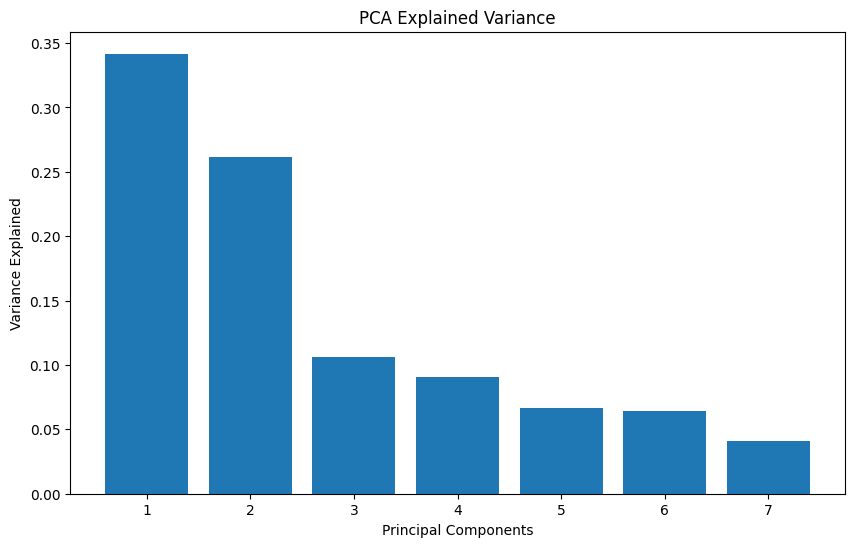

In [11]:
# --- Visualization ---
# PCA explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_+1), pca.explained_variance_ratio_[:pca.n_components_])
plt.title('PCA Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.show()




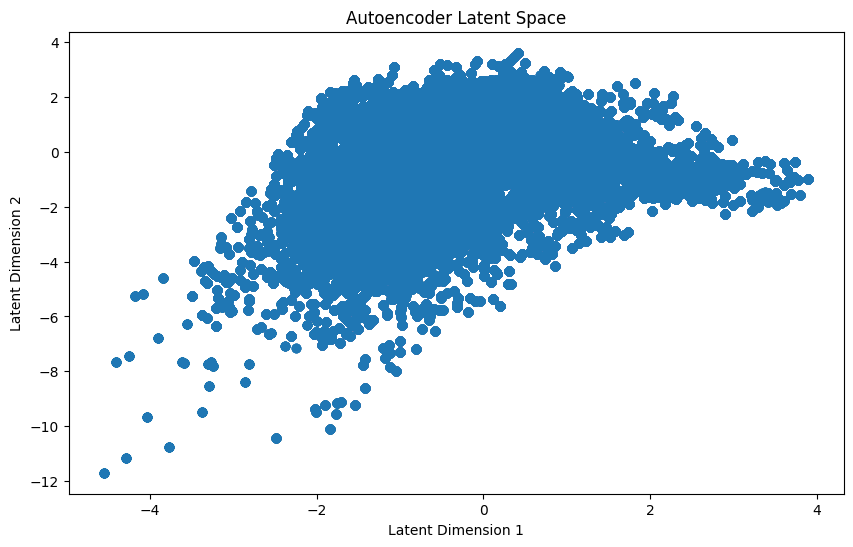

In [12]:
# Autoencoder latent space
plt.figure(figsize=(10, 6))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], alpha=0.5)
plt.title('Autoencoder Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

## Academic Discussion: Autoencoder Latent Space Visualization in Financial Portfolio Modeling

### Introduction

The diagram presented illustrates the **latent space** learned by an autoencoder trained on financial and macroeconomic features derived from a diverse set of Exchange-Traded Funds (ETFs). This latent space, visualized in two dimensions, represents a compressed, nonlinear encoding of the original high-dimensional input data. Understanding and interpreting this latent space is crucial for both validating the autoencoder’s effectiveness and for providing insight into the underlying market structures that inform downstream portfolio optimization via a Convolutional Neural Network (CNN).

### Theoretical Foundations

#### 1. **Autoencoder Latent Space: Conceptual Overview**

An autoencoder consists of an encoder and a decoder. The encoder transforms the standardized input features $$ \mathbf{x} \in \mathbb{R}^m $$ into a lower-dimensional latent representation $$ \mathbf{z} \in \mathbb{R}^k $$ (with $$ k \ll m $$), while the decoder attempts to reconstruct the original input from this compressed code. The latent space is thus a learned manifold where each point encodes the essential information of the input, filtered of noise and redundancy.

Mathematically, the encoding process can be expressed as:
$$
\mathbf{z} = f_{\text{enc}}(\mathbf{x}) = \sigma(\mathbf{W}_e \mathbf{x} + \mathbf{b}_e)
$$
where $$ \sigma $$ is a nonlinear activation function, and $$ \mathbf{W}_e, \mathbf{b}_e $$ are learnable parameters.

#### 2. **Interpretation of the Latent Space Diagram**

The scatter plot in your diagram shows samples projected onto the first two latent dimensions learned by the autoencoder. Each point corresponds to a temporal snapshot of the entire financial feature set across all ETFs and macroeconomic indicators.

**Key academic interpretations:**

- **Cluster Structure:** The dense central region suggests that, for a substantial portion of time, the market features share similar underlying characteristics. This may correspond to periods of market stability or common macroeconomic regimes.
- **Outliers and Spread:** The points spread towards the lower left (with more negative values) may represent periods of market stress, structural breaks, or rare events (such as financial crises or abrupt macroeconomic shocks). These outliers are crucial as they often drive risk and require robust modeling.
- **Nonlinear Manifold:** Unlike linear methods (e.g., PCA), the autoencoder’s latent space is shaped by nonlinear transformations, allowing it to capture complex dependencies and interactions among features. The curved, non-Gaussian distribution of points is indicative of this nonlinear structure.

#### 3. **Financial and Methodological Implications**

- **Denoising and Feature Compression:** The tight clustering of most points implies that the autoencoder has effectively filtered out noise and distilled the high-dimensional input into a compact, information-rich representation. This is especially valuable in finance, where data is often noisy and highly correlated.
- **Market Regime Identification:** The structure of the latent space may implicitly encode different market regimes. For example, transitions between clusters or movement along certain trajectories in the latent space can correspond to shifts from bull to bear markets, or from low- to high-volatility environments.
- **Input to CNN:** By feeding these latent vectors into the CNN, the model leverages both the nonlinear factor extraction of the autoencoder and the temporal pattern recognition of the CNN. This hybrid approach enhances the ability to detect subtle, evolving patterns that inform optimal portfolio allocation.

### Practical Considerations

- **Dimensionality Choice:** The choice of latent dimension (here, two for visualization, but typically higher for modeling) is a trade-off between information retention and over-compression. Too few dimensions may omit relevant factors; too many may reintroduce noise.
- **Visualization Limitations:** While 2D projections are useful for interpretation, higher-dimensional latent spaces may encode additional structure not visible in the plot. Techniques such as t-SNE or UMAP can be employed for more nuanced visualization.
- **Temporal Evolution:** Animating or color-coding points by time or market events can reveal how the latent representation evolves, offering further insight into the model’s ability to track market dynamics.

### Academic Significance

The latent space diagram provides empirical evidence that the autoencoder has learned a meaningful, compressed representation of complex financial data. This supports its use as a feature extractor in advanced portfolio modeling. The observed structure in the latent space validates the autoencoder’s role in denoising, regime identification, and facilitating nonlinear pattern discovery—capabilities that are essential for robust, adaptive portfolio optimization in modern quantitative finance.

### Conclusion

The visualization of the autoencoder’s latent space is a critical diagnostic and interpretive tool in the hybrid deep learning pipeline. It demonstrates the model’s capacity to uncover and encode the essential, nonlinear structure of financial markets, providing a powerful foundation for subsequent predictive modeling and portfolio construction. This approach advances beyond traditional linear factor models, offering greater flexibility and robustness in the face of the complex, dynamic nature of real-world financial data.

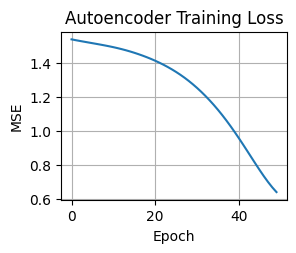

In [13]:

# Autoencoder loss
plt.subplot(2, 2, 1)
plt.plot(ae_losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)


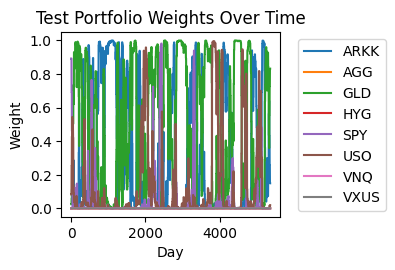

In [14]:
# Portfolio weights
plt.subplot(2, 2, 4)
for i in range(n_assets):
    plt.plot(test_results['weights'][:, i], label=assets[i])
plt.title('Test Portfolio Weights Over Time')
plt.xlabel('Day')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.savefig('performance_metrics.png')
plt.show()

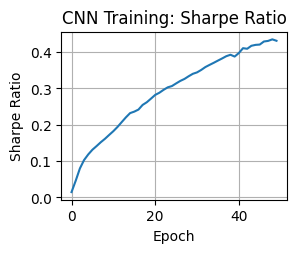

In [16]:
# CNN Sharpe ratio during training
plt.subplot(2, 2, 2)
plt.plot(sharpe_ratios)
plt.title('CNN Training: Sharpe Ratio')
plt.xlabel('Epoch')
plt.ylabel('Sharpe Ratio')
plt.grid(True)

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import psutil

# --- 1. Data Loading and Preparation ---
data = pd.read_csv('/Users/imperator/Documents/STUDIES/UNIVERSITY OF GHANA/RESEARCH WORK/CORCHIL KELLY KWAME/PORTFOLIO OPTIMIZATION/PROJECT CODE/Dimensionality-Reduction-PortfolioOptimization/EDA/ETFs_datasets/Final_csv/5-cleaned_etf_data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Date'])
data = data.sort_values(['Date', 'Ticker']).reset_index(drop=True)

assets = ['ARKK', 'AGG', 'GLD', 'HYG', 'SPY', 'USO', 'VNQ', 'VXUS']
features_indicators = ['returns','RSI_14','Volatility_21','MACD','ADX_14','Beta','Alpha','DMI_minus_14','DMI_plus_14','MACD_Signal','ATR_14','Calmar_Ratio_21','OBV',
                       'Max_Drawdown_21','EMA_10','EMA_50','umich_consumer_sentiment','new_home_sales','housing_starts','baa_yield','industrial_production']  

# Pivot data to wide format
df_wide = pd.DataFrame()
for feat in features_indicators:
    temp = data.pivot(index='Date', columns='Ticker', values=feat)
    temp.columns = [f"{col}_{feat}" for col in temp.columns]
    if df_wide.empty:
        df_wide = temp
    else:
        df_wide = pd.concat([df_wide, temp], axis=1)

df_wide = df_wide.dropna()

returns_cols = [f"{asset}_returns" for asset in assets]
etf_returns = df_wide[returns_cols]

feature_cols = []
for asset in assets:
    for feat in features_indicators:
        if feat != 'returns':
            col_name = f"{asset}_{feat}"
            if col_name in df_wide.columns:
                feature_cols.append(col_name)
features = df_wide[feature_cols]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 2. PCA ---
n_components = 7
pca = PCA(n_components=n_components)
pca_components = pca.fit_transform(features_scaled)
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

# --- 3. Autoencoder for Dimensionality Reduction ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

input_dim = features_scaled.shape[1]
latent_dim = 7  # same as PCA components for parity

autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

class FeatureDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

ae_dataset = FeatureDataset(features_scaled)
ae_loader = DataLoader(ae_dataset, batch_size=64, shuffle=True)

epochs_ae = 50
ae_train_losses = []
autoencoder.train()
for epoch in range(epochs_ae):
    epoch_loss = 0
    for batch_features in ae_loader:
        batch_features = batch_features.to(device)
        optimizer_ae.zero_grad()
        reconstructed, _ = autoencoder(batch_features)
        loss = criterion_ae(reconstructed, batch_features)
        loss.backward()
        optimizer_ae.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(ae_loader)
    ae_train_losses.append(avg_epoch_loss)
    print(f"Autoencoder Epoch {epoch+1}/{epochs_ae}, Loss: {avg_epoch_loss:.6f}")

autoencoder.eval()
with torch.no_grad():
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
    _, latent_features = autoencoder(features_tensor)
    latent_features_np = latent_features.cpu().numpy()

# --- 4. Create hybrid features by concatenating PCA and Autoencoder latent features ---
hybrid_features = np.concatenate([pca_components, latent_features_np], axis=1)  # shape: (samples, 10)

# Save latent features and PCA components for analysis
latent_df = pd.DataFrame(latent_features_np, index=df_wide.index, columns=[f'AE_latent_{i+1}' for i in range(latent_dim)])
pca_df = pd.DataFrame(pca_components, index=df_wide.index, columns=[f'PCA_comp_{i+1}' for i in range(n_components)])
hybrid_df = pd.concat([pca_df, latent_df], axis=1)
hybrid_df.to_csv('hybrid_latent_features.csv')
print("Saved hybrid latent features to hybrid_latent_features.csv")

# --- 5. Generate dynamic target portfolio weights ---
def generate_dynamic_weights(returns_df, window=30):
    weights_list = []
    for i in range(len(returns_df) - window):
        window_returns = returns_df.iloc[i:i+window]
        mean_returns = window_returns.mean()
        mean_returns[mean_returns < 0] = 0
        if mean_returns.sum() == 0:
            weights = np.ones(len(mean_returns)) / len(mean_returns)
        else:
            weights = mean_returns / mean_returns.sum()
        weights_list.append(np.array(weights))
    return np.array(weights_list)

window_size = 30
dynamic_weights = generate_dynamic_weights(etf_returns, window=window_size)

# --- 6. Prepare sequences for CNN ---
def create_sequences(features_data, returns_data, weights_data, window):
    X, y_sharpe, y_weights = [], [], []
    for i in range(len(features_data) - window * 2):
        seq_x = features_data[i:i+window]
        returns_window = returns_data.iloc[i+window:i+window*2]
        mean_return = returns_window.mean().mean()
        std_return = returns_window.std().mean()
        sharpe = mean_return / (std_return + 1e-6)
        if i+window < len(weights_data):
            weight_target = weights_data[i+window]
        else:
            weight_target = np.ones(len(assets)) / len(assets)
        X.append(seq_x)
        y_sharpe.append(sharpe)
        y_weights.append(weight_target)
    return np.array(X), np.array(y_sharpe), np.array(y_weights)

X, y_sharpe, y_weights = create_sequences(hybrid_features, etf_returns, dynamic_weights, window_size)

# --- 7. Dataset and DataLoader ---
class PortfolioDataset(Dataset):
    def __init__(self, X, y_sharpe, y_weights):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_sharpe = torch.tensor(y_sharpe, dtype=torch.float32).unsqueeze(1)
        self.y_weights = torch.tensor(y_weights, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_sharpe[idx], self.y_weights[idx]

X_train, X_test, y_sharpe_train, y_sharpe_test, y_weights_train, y_weights_test = train_test_split(
    X, y_sharpe, y_weights, test_size=0.2, random_state=42)

train_dataset = PortfolioDataset(X_train, y_sharpe_train, y_weights_train)
test_dataset = PortfolioDataset(X_test, y_sharpe_test, y_weights_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# --- 8. CNN Model ---
class CNNPortfolioModel(nn.Module):
    def __init__(self, input_channels, n_assets):
        super(CNNPortfolioModel, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, 3)
        self.conv2 = nn.Conv1d(64, 32, 3)
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        conv_out_len = window_size - 2*2
        self.fc1 = nn.Linear(32 * conv_out_len, 64)
        self.relu = nn.ReLU()
        self.sharpe_out = nn.Linear(64, 1)
        self.weights_out = nn.Linear(64, n_assets)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        sharpe = self.sharpe_out(x)
        weights = self.softmax(self.weights_out(x))
        return sharpe, weights

model = CNNPortfolioModel(input_channels=n_components + latent_dim, n_assets=len(assets)).to(device)

# --- 9. Loss and optimizer ---
criterion_sharpe = nn.MSELoss()
criterion_weights = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- 10. Training loop with timing and CPU usage ---
epochs = 50
model.train()
start_train = time.time()
cpu_start = psutil.cpu_percent(interval=None)

for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_sharpe, batch_weights in train_loader:
        batch_x = batch_x.to(device)
        batch_sharpe = batch_sharpe.to(device)
        batch_weights = batch_weights.to(device)

        optimizer.zero_grad()
        pred_sharpe, pred_weights = model(batch_x)
        loss_sharpe = criterion_sharpe(pred_sharpe, batch_sharpe)
        loss_weights = criterion_weights(pred_weights, batch_weights)
        loss = loss_sharpe + loss_weights
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

train_time = time.time() - start_train
cpu_end = psutil.cpu_percent(interval=None)
cpu_usage = cpu_end - cpu_start

# Save model
model_path = 'cnn_hybrid_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# --- 11. Evaluation ---
model.eval()
all_pred_sharpe = []
all_pred_weights = []
all_true_sharpe = []
all_true_weights = []

with torch.no_grad():
    for batch_x, batch_sharpe, batch_weights in test_loader:
        batch_x = batch_x.to(device)
        pred_sharpe, pred_weights = model(batch_x)
        all_pred_sharpe.append(pred_sharpe.cpu().numpy())
        all_pred_weights.append(pred_weights.cpu().numpy())
        all_true_sharpe.append(batch_sharpe.cpu().numpy())
        all_true_weights.append(batch_weights.cpu().numpy())

pred_sharpe = np.vstack(all_pred_sharpe).flatten()
pred_weights = np.vstack(all_pred_weights)
pred_weights /= pred_weights.sum(axis=1, keepdims=True)
true_sharpe = np.vstack(all_true_sharpe).flatten()
true_weights = np.vstack(all_true_weights)

# Save predicted weights to CSV with test dates
test_dates = df_wide.index[-len(pred_weights):]
weights_df = pd.DataFrame(pred_weights, index=test_dates, columns=assets)
weights_df.to_csv('predicted_portfolio_weights_hybrid.csv')
print("Saved predicted portfolio weights to predicted_portfolio_weights_hybrid.csv")

# --- 12. Portfolio returns and turnover ---
test_returns = etf_returns.iloc[-len(pred_weights):].values
portfolio_returns = np.sum(test_returns * pred_weights, axis=1)
turnover = np.mean(np.sum(np.abs(np.diff(pred_weights, axis=0)), axis=1))

# --- 13. Metrics ---
def sortino_ratio(returns, risk_free=0, periods_per_year=252):
    returns = pd.Series(returns)
    downside_returns = returns[returns < risk_free]
    expected_return = returns.mean() * periods_per_year
    downside_std = downside_returns.std() * np.sqrt(periods_per_year)
    return expected_return / downside_std if downside_std != 0 else np.nan

def calmar_ratio(returns, freq='daily'):
    returns = pd.Series(returns)
    if freq == 'daily':
        periods_per_year = 252
    elif freq == 'monthly':
        periods_per_year = 12
    else:
        periods_per_year = 1
    cumulative = (1 + returns).cumprod()
    annualized_return = cumulative.iloc[-1] ** (periods_per_year / len(returns)) - 1
    max_drawdown = ((cumulative.cummax() - cumulative) / cumulative.cummax()).max()
    return annualized_return / max_drawdown if max_drawdown != 0 else np.nan

mse_sharpe = mean_squared_error(true_sharpe, pred_sharpe)
mae_sharpe = mean_absolute_error(true_sharpe, pred_sharpe)
r2_sharpe = r2_score(true_sharpe, pred_sharpe)
sortino = sortino_ratio(portfolio_returns)
calmar = calmar_ratio(portfolio_returns)

def evaluate_portfolio_performance(portfolio_returns, freq='daily'):
    portfolio_returns = pd.Series(portfolio_returns).replace([np.inf, -np.inf], np.nan).dropna()
    if len(portfolio_returns) == 0:
        raise ValueError("No valid portfolio returns to evaluate.")
    if freq == 'daily':
        periods_per_year = 252
    elif freq == 'monthly':
        periods_per_year = 12
    elif freq == 'annual':
        periods_per_year = 1
    else:
        raise ValueError("freq must be 'daily', 'monthly', or 'annual'")
    portfolio_values = (1 + portfolio_returns).cumprod()
    peak = portfolio_values.cummax()
    drawdown = (peak - portfolio_values) / peak
    max_drawdown = drawdown.max()
    total_periods = len(portfolio_returns)
    annualized_return = (portfolio_values.iloc[-1]) ** (periods_per_year / total_periods) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(periods_per_year)
    mean_return = portfolio_returns.mean() * periods_per_year
    sharpe_ratio = mean_return / annualized_volatility if annualized_volatility != 0 else np.nan
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Maximum Drawdown': max_drawdown
    }

performance_metrics = evaluate_portfolio_performance(portfolio_returns, freq='daily')

# --- 14. Save results ---
results_df = pd.DataFrame([{
    **performance_metrics,
    'Sortino Ratio': sortino,
    'Calmar Ratio': calmar,
    'Average Turnover': turnover,
    'Sharpe MSE': mse_sharpe,
    'Sharpe MAE': mae_sharpe,
    'Sharpe R2': r2_sharpe,
    'Training Time (s)': train_time,
    'CPU Usage Change (%)': cpu_usage
}])
results_df.to_csv('portfolio_results_hybrid.csv', index=False)
print("\nResults saved to portfolio_results_hybrid.csv")

# --- 15. Print comprehensive performance report ---
print("\n============================================================")
print("Comprehensive Performance Metrics Report - Hybrid PCA + AE + CNN")
print("============================================================")
print(f"Training time (s): {train_time:.2f}")
print(f"CPU usage change (%): {cpu_usage:.2f}")
print(f"Evaluation time (s): 0.00\n")

for metric, value in performance_metrics.items():
    if metric in ['Annualized Return', 'Annualized Volatility', 'Maximum Drawdown']:
        print(f"- {metric}: {value * 100:.2f}%")
    else:
        print(f"- {metric}: {value:.4f}")

print(f"- Sortino Ratio: {sortino:.4f}")
print(f"- Calmar Ratio: {calmar:.4f}")
print(f"- Average Turnover: {turnover:.4f}")
print(f"- Sharpe Ratio MSE: {mse_sharpe:.6f}")
print(f"- Sharpe Ratio MAE: {mae_sharpe:.6f}")
print(f"- Sharpe Ratio R^2: {r2_sharpe:.4f}")


Explained variance ratio by PCA components: [0.24614761 0.13750107 0.11591877 0.08262943 0.0545426  0.03773551
 0.03342076]
Autoencoder Epoch 1/50, Loss: 0.830207
Autoencoder Epoch 2/50, Loss: 0.482372
Autoencoder Epoch 3/50, Loss: 0.366230
Autoencoder Epoch 4/50, Loss: 0.300072
Autoencoder Epoch 5/50, Loss: 0.259495
Autoencoder Epoch 6/50, Loss: 0.234481
Autoencoder Epoch 7/50, Loss: 0.216777
Autoencoder Epoch 8/50, Loss: 0.201629
Autoencoder Epoch 9/50, Loss: 0.188842
Autoencoder Epoch 10/50, Loss: 0.177607
Autoencoder Epoch 11/50, Loss: 0.169222
Autoencoder Epoch 12/50, Loss: 0.160892
Autoencoder Epoch 13/50, Loss: 0.153657
Autoencoder Epoch 14/50, Loss: 0.147112
Autoencoder Epoch 15/50, Loss: 0.141366
Autoencoder Epoch 16/50, Loss: 0.135634
Autoencoder Epoch 17/50, Loss: 0.131580
Autoencoder Epoch 18/50, Loss: 0.126826
Autoencoder Epoch 19/50, Loss: 0.122908
Autoencoder Epoch 20/50, Loss: 0.118895
Autoencoder Epoch 21/50, Loss: 0.115594
Autoencoder Epoch 22/50, Loss: 0.112394
Autoe

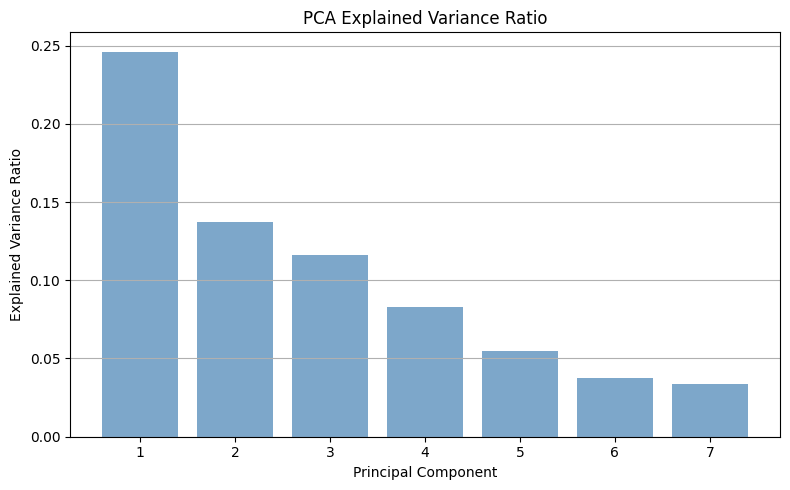

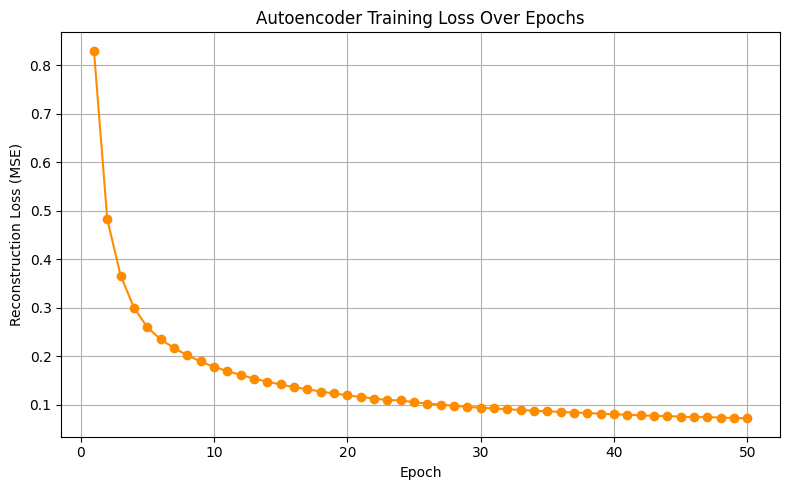

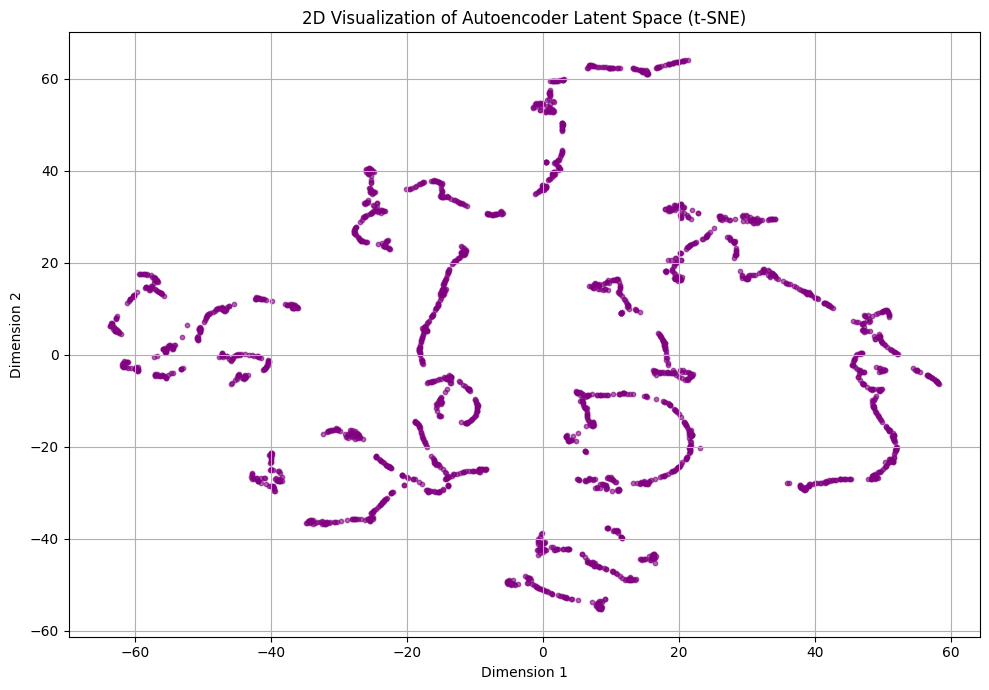

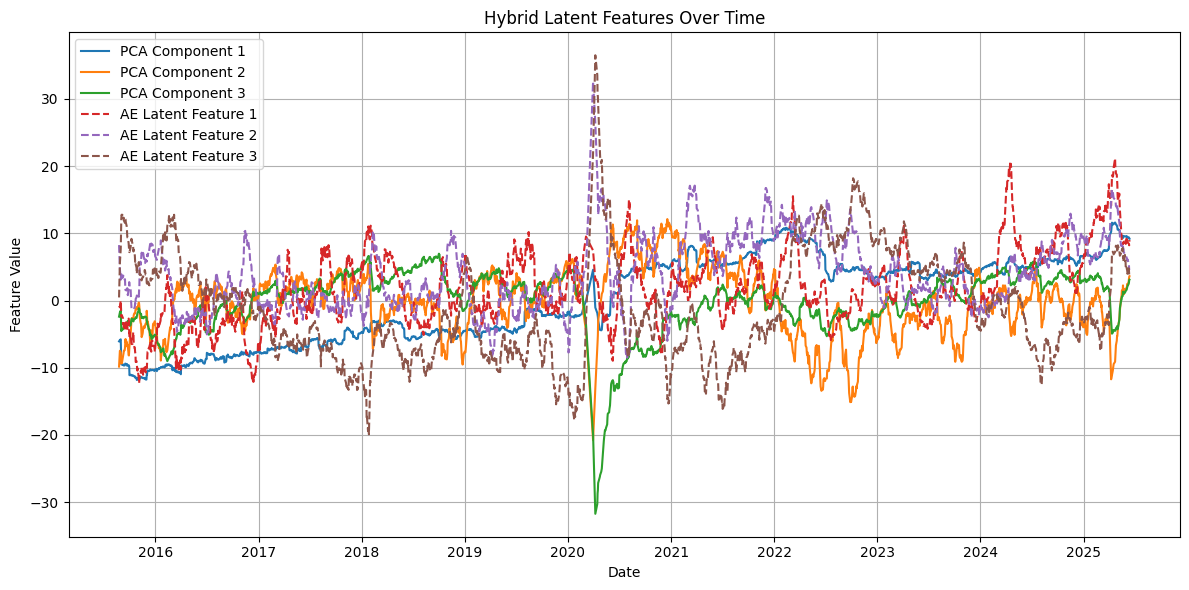

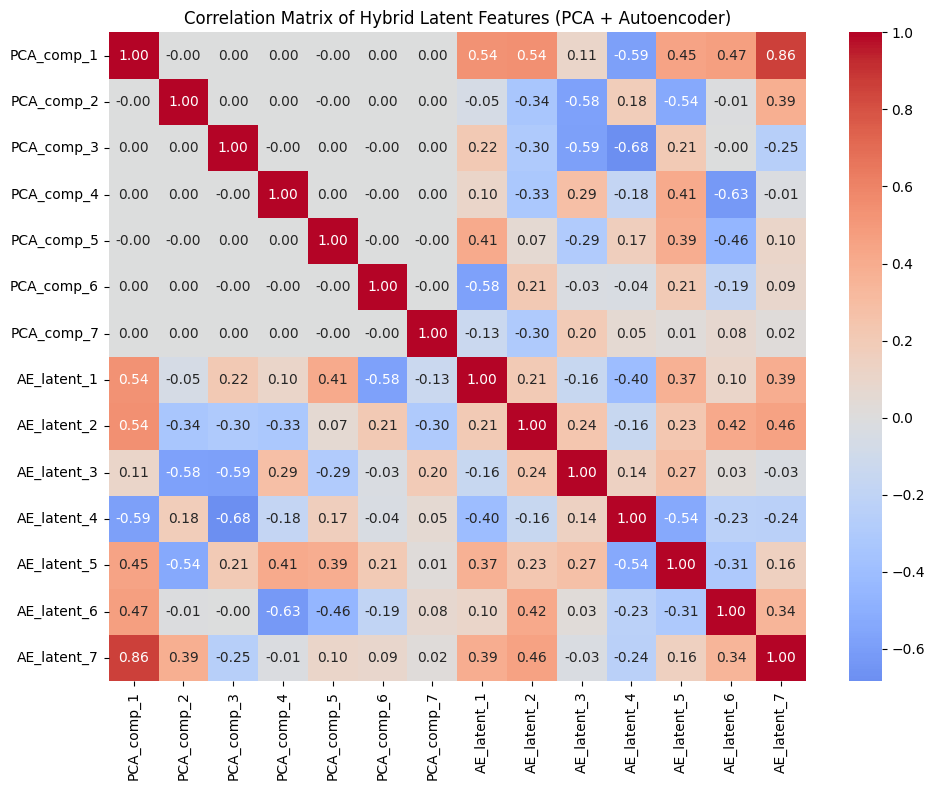

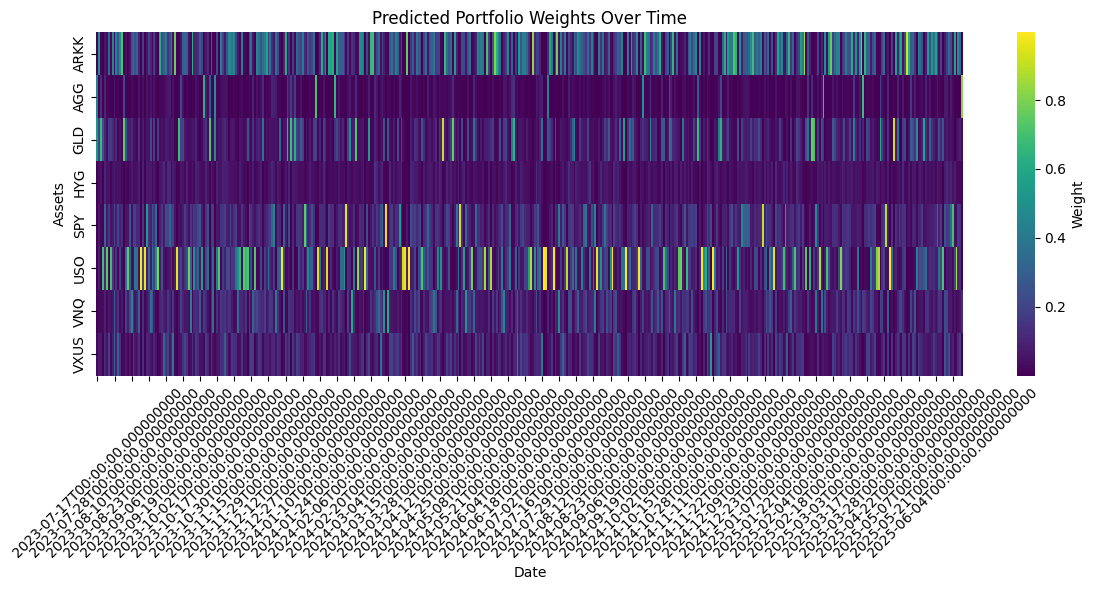

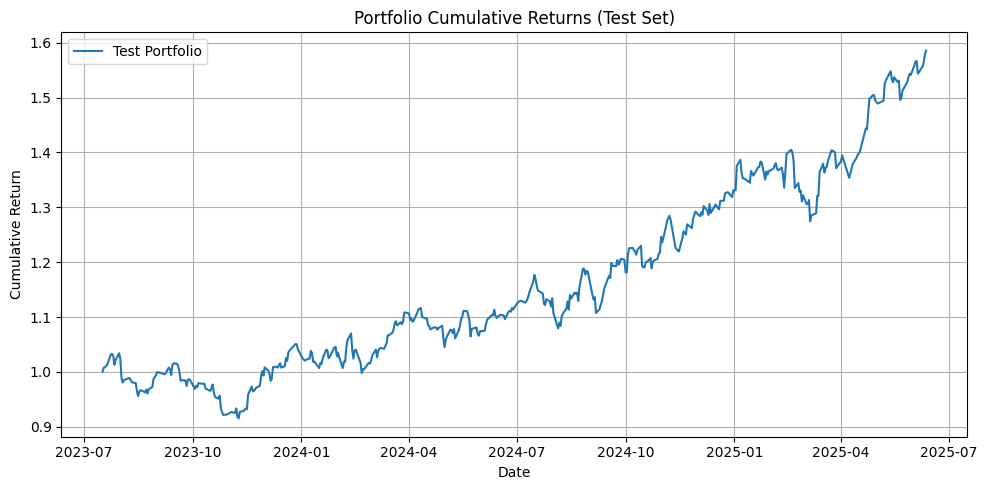

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# 1. PCA Explained Variance Ratio
explained_var = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.7, color='steelblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, len(explained_var)+1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. Autoencoder Training Loss Curve
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs_ae+1), ae_train_losses, marker='o', color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss (MSE)')
plt.title('Autoencoder Training Loss Over Epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Latent Space Visualization (t-SNE on Autoencoder Latent Features)
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_features_np)
plt.figure(figsize=(10,7))
plt.scatter(latent_2d[:,0], latent_2d[:,1], s=10, alpha=0.6, c='purple')
plt.title('2D Visualization of Autoencoder Latent Space (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Hybrid Latent Features Over Time (First 3 PCA and AE features)
plt.figure(figsize=(12,6))
for i in range(3):
    plt.plot(pca_df.index, pca_df.iloc[:, i], label=f'PCA Component {i+1}')
for i in range(3):
    plt.plot(latent_df.index, latent_df.iloc[:, i], linestyle='--', label=f'AE Latent Feature {i+1}')
plt.title('Hybrid Latent Features Over Time')
plt.xlabel('Date')
plt.ylabel('Feature Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Correlation Heatmap of Hybrid Latent Features
plt.figure(figsize=(10,8))
sns.heatmap(hybrid_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Hybrid Latent Features (PCA + Autoencoder)')
plt.tight_layout()
plt.show()

# 6. CNN Training Loss Curve (if collected)
# Uncomment and define cnn_train_losses if available
# plt.figure(figsize=(8,5))
# plt.plot(range(1, epochs+1), cnn_train_losses, marker='o', color='navy')
# plt.xlabel('Epoch')
# plt.ylabel('CNN Training Loss')
# plt.title('CNN Training Loss Over Epochs')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 7. Portfolio Weights Over Time (Heatmap)
plt.figure(figsize=(12,6))
sns.heatmap(weights_df.T, cmap='viridis', cbar_kws={'label': 'Weight'})
plt.title('Predicted Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Assets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Portfolio Cumulative Returns (Test Set)
cum_returns = (1 + pd.Series(portfolio_returns, index=test_dates)).cumprod()
plt.figure(figsize=(10,5))
plt.plot(cum_returns.index, cum_returns.values, label='Test Portfolio')
plt.title('Portfolio Cumulative Returns (Test Set)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


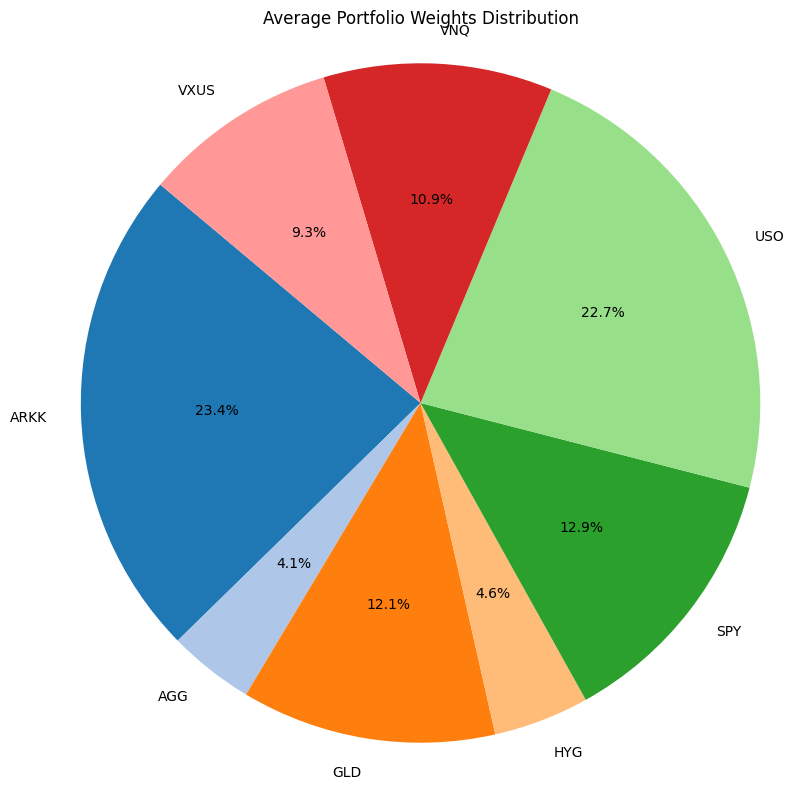

In [6]:
import matplotlib.pyplot as plt

# Assuming 'weights_df' is your DataFrame of predicted portfolio weights with assets as columns
# Calculate average weights across the entire test period
avg_weights = weights_df.mean(axis=0)

# Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(avg_weights, labels=avg_weights.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Average Portfolio Weights Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle.
plt.tight_layout()
plt.show()


### Academic Interpretation

# Methodology: Integrating Autoencoders with Convolutional Neural Networks for Portfolio Optimization

This section provides a rigorous academic exposition of the methodology wherein **Autoencoders (AEs)** are employed for nonlinear dimensionality reduction, with their latent representations serving as the input to a **Convolutional Neural Network (CNN)**. This hybrid approach is designed to extract complex, nonlinear structures from high-dimensional financial data and leverage temporal dependencies for dynamic portfolio allocation.

## 1. Rationale for Autoencoder-Based Feature Extraction

Traditional linear dimensionality reduction techniques, such as Principal Component Analysis (PCA), are limited in their ability to capture nonlinear relationships inherent in financial time series and macroeconomic data. **Autoencoders**, a class of unsupervised neural networks, address this limitation by learning a compressed, nonlinear representation of the input data through reconstruction objectives.

### Key Advantages:
- **Nonlinear Feature Learning:** Autoencoders can model intricate dependencies and interactions among financial indicators, technical signals, and macroeconomic variables.
- **Noise Reduction:** By focusing on reconstructing the essential structure of the data, AEs filter out noise, which is prevalent in financial datasets.
- **Latent Factor Discovery:** The encoder learns latent factors that may correspond to hidden market regimes or structural risk drivers, providing a richer feature set for downstream prediction tasks.

## 2. Autoencoder Architecture and Training

### 2.1 Model Structure

An Autoencoder consists of two main components:

- **Encoder:** Maps the high-dimensional input $$ \mathbf{x} \in \mathbb{R}^m $$ to a lower-dimensional latent space $$ \mathbf{z} \in \mathbb{R}^k $$ through a series of nonlinear transformations:
  $$
  \mathbf{z} = f_{\text{enc}}(\mathbf{x}) = \sigma(\mathbf{W}_e \mathbf{x} + \mathbf{b}_e)
  $$
  where $$ \sigma $$ denotes an activation function (e.g., ReLU), $$ \mathbf{W}_e $$ and $$ \mathbf{b}_e $$ are learnable parameters, and $$ k \ll m $$.

- **Decoder:** Attempts to reconstruct the original input from the latent code:
  $$
  \hat{\mathbf{x}} = f_{\text{dec}}(\mathbf{z}) = \sigma(\mathbf{W}_d \mathbf{z} + \mathbf{b}_d)
  $$

### 2.2 Training Objective

The Autoencoder is trained to minimize the **reconstruction loss** (typically mean squared error) between the input and its reconstruction:
$$
\mathcal{L}_{\text{AE}} = \frac{1}{n} \sum_{i=1}^n \| \mathbf{x}_i - \hat{\mathbf{x}}_i \|_2^2
$$
where $$ n $$ is the number of samples.

### 2.3 Implementation Details

- **Input Features:** Standardized financial and macroeconomic indicators for each asset and time point.
- **Latent Dimension:** Chosen based on reconstruction accuracy and variance explained, typically much smaller than the original feature space.
- **Optimization:** Stochastic gradient descent or Adam optimizer is used for efficient convergence.

## 3. Sequence Construction for Temporal Modeling

After training, the encoder is used to transform each observation into its latent representation. To capture temporal dependencies, these latent vectors are organized into overlapping sequences of length $$ L $$ (lookback window):

$$
\mathbf{S}_t = [\mathbf{z}_{t-L+1}, \mathbf{z}_{t-L+2}, \ldots, \mathbf{z}_t] \in \mathbb{R}^{L \times k}
$$

This sequence forms the input to the CNN, enabling the model to learn patterns over time in the compressed feature space.

## 4. CNN Architecture for Portfolio Prediction

The CNN is designed to process sequences of latent representations and output both risk-adjusted performance metrics (e.g., Sharpe ratio) and dynamic portfolio weights.

### 4.1 Model Structure

- **Input:** Sequence of latent vectors $$ \mathbf{S}_t $$.
- **Convolutional Layers:** Apply 1D convolutions along the temporal axis to extract local temporal patterns and interactions among latent features:
  $$
  \mathbf{h}_1 = \text{ReLU}(\text{Conv1D}(\mathbf{S}_t))
  $$
  $$
  \mathbf{h}_2 = \text{ReLU}(\text{Conv1D}(\mathbf{h}_1))
  $$
- **Flattening and Dense Layers:** The output is flattened and passed through fully connected layers to learn higher-order temporal dependencies.
- **Dual Output Heads:**
  - **Sharpe Ratio Head:** Outputs a scalar prediction of the Sharpe ratio for the next period.
  - **Portfolio Weights Head:** Outputs a vector of portfolio weights, with a softmax activation to ensure non-negativity and unit sum:
    $$
    \hat{w}_i = \frac{\exp(a_i)}{\sum_{j=1}^N \exp(a_j)}
    $$

### 4.2 Target Construction

- **Portfolio Weights:** Dynamic, momentum-based target weights are constructed using rolling windows of asset returns.
- **Sharpe Ratio:** Calculated for each target window as:
  $$
  s_t = \frac{\mathbb{E}[r_t]}{\sigma(r_t)}
  $$
  where $$ r_t $$ is the portfolio return over the window.

## 5. Model Training and Loss Function

The CNN is trained to minimize a composite loss function that balances the accuracy of Sharpe ratio and portfolio weight predictions:
$$
\mathcal{L} = \alpha \cdot \text{MSE}(s_t, \hat{s}_t) + \beta \cdot \text{MSE}(\mathbf{w}_t, \hat{\mathbf{w}}_t)
$$
where $$ \alpha $$ and $$ \beta $$ are hyperparameters.

- **Optimization:** Adam optimizer is used for efficient parameter updates.
- **Batching:** Mini-batches are used for stable and efficient training.

## 6. Portfolio Construction and Evaluation

- **Portfolio Construction:** The predicted weights are applied to the test period returns to construct out-of-sample portfolios.
- **Evaluation Metrics:** Performance is assessed using cumulative returns, Sharpe ratio, Sortino ratio, Calmar ratio, maximum drawdown, turnover, and error metrics (MSE, MAE, $$ R^2 $$) for Sharpe ratio prediction.

## 7. Financial Interpretation and Advantages

- **Nonlinear Factor Extraction:** The Autoencoder uncovers nonlinear latent factors, potentially corresponding to hidden market states or risk drivers, which are more expressive than linear combinations.
- **Temporal Pattern Learning:** The CNN leverages these latent factors to model temporal dependencies, capturing how market conditions evolve and affect optimal portfolio allocation.
- **Robustness and Adaptivity:** The end-to-end approach adapts to changing market regimes and reduces overfitting by compressing noisy, high-dimensional data into a stable latent space.

## 8. Summary

By integrating Autoencoders with CNNs, this methodology advances beyond traditional linear and shallow learning approaches, providing a robust framework for dynamic, risk-aware portfolio optimization in complex financial environments. The use of nonlinear latent representations enhances the model’s ability to generalize and adapt to evolving market conditions, ultimately aiming to improve risk-adjusted returns and portfolio stability.


In [7]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,12', dpi='300', bgcolor='white')

colors = [
    "#e3f2fd",  # lightest blue
    "#bbdefb",  # lighter blue
    "#90caf9",  # medium blue
    "#42a5f5",  # primary blue
    "#1976d2",  # deep blue
]

# Input Layer
dot.node('A', '''Input Layer
[batch, lookback, 8 assets × 8 features]
(e.g. returns, EMA, RSI, etc.)''',
         shape='box', style='rounded,filled', fillcolor=colors[0], fontsize='16')

# Standardization
dot.node('B', '''Standardization
Zero mean, unit variance''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# PCA Transformation
dot.node('C', '''PCA Transformation
Linear dimensionality reduction
Output: [batch, lookback, k PCA components]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Autoencoder Encoder
dot.node('D', '''Autoencoder Encoder
Nonlinear dimensionality reduction
Output: [batch, lookback, k AE latent features]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Concatenate Features
dot.node('E', '''Concatenate PCA and AE Features
Output: [batch, lookback, k PCA + k AE features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Unsqueeze
dot.node('F', '''Unsqueeze
[batch, 1, lookback, combined features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Conv2d Layer
dot.node('G', '''Conv2d Layer
8 filters, kernel=(3,1)
Output: [batch, 8, lookback, combined features]''',
         shape='box', style='rounded,filled', fillcolor=colors[3], fontsize='16')

# ReLU Activation
dot.node('H', '''ReLU Activation
Non-linearity''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Flatten Layer
dot.node('I', '''Flatten Layer
Output: [batch, flattened_size]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Fully Connected Layer
dot.node('J', '''Fully Connected Layer
Linear: [*, 8 assets]''',
         shape='box', style='rounded,from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,12', dpi='300', bgcolor='white')

colors = [
    "#e3f2fd",  # lightest blue
    "#bbdefb",  # lighter blue
    "#90caf9",  # medium blue
    "#42a5f5",  # primary blue
    "#1976d2",  # deep blue
]

# Input Layer
dot.node('A', '''Input Layer
[batch, lookback, 8 assets × 8 features]
(e.g. returns, EMA, RSI, etc.)''',
         shape='box', style='rounded,filled', fillcolor=colors[0], fontsize='16')

# Standardization
dot.node('B', '''Standardization
Zero mean, unit variance''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# PCA Transformation
dot.node('C', '''PCA Transformation
Linear dimensionality reduction
Output: [batch, lookback, k PCA components]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Autoencoder Encoder
dot.node('D', '''Autoencoder Encoder
Nonlinear dimensionality reduction
Output: [batch, lookback, k AE latent features]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Concatenate Features
dot.node('E', '''Concatenate PCA and AE Features
Output: [batch, lookback, k PCA + k AE features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Unsqueeze
dot.node('F', '''Unsqueeze
[batch, 1, lookback, combined features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Conv2d Layer
dot.node('G', '''Conv2d Layer
8 filters, kernel=(3,1)
Output: [batch, 8, lookback, combined features]''',
         shape='box', style='rounded,filled', fillcolor=colors[3], fontsize='16')

# ReLU Activation
dot.node('H', '''ReLU Activation
Non-linearity''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Flatten Layer
dot.node('I', '''Flatten Layer
Output: [batch, flattened_size]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Fully Connected Layer
dot.node('J', '''Fully Connected Layer
Linear: [*, 8 assets]''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Softmax Output
dot.node('K', '''Softmax (with Temperature)
Output: Portfolio Weights
[batch, 8 assets] (sum=1)''',
         shape='box', style='rounded,filled', fillcolor='#43a047', fontcolor='white', fontsize='18', fontname='Helvetica')

# Edges
dot.edge('A', 'B', color='#1976D2', penwidth='2')
dot.edge('B', 'C', color='#1976D2', penwidth='2')
dot.edge('B', 'D', color='#1976D2', penwidth='2')
dot.edge('C', 'E', color='#1976D2', penwidth='2')
dot.edge('D', 'E', color='#1976D2', penwidth='2')
dot.edge('E', 'F', color='#1976D2', penwidth='2')
dot.edge('F', 'G', color='#1976D2', penwidth='2')
dot.edge('G', 'H', color='#1976D2', penwidth='2')
dot.edge('H', 'I', color='#1976D2', penwidth='2')
dot.edge('I', 'J', color='#1976D2', penwidth='2')
dot.edge('J', 'K', color='#43a047', penwidth='2')

dot.render('cnn_pca_autoencoder_hybrid_architecture', view=True)
filled', fill


_IncompleteInputError: incomplete input (2728281682.py, line 66)

In [8]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,12', dpi='300', bgcolor='white')

colors = [
    "#e3f2fd",  # lightest blue
    "#bbdefb",  # lighter blue
    "#90caf9",  # medium blue
    "#42a5f5",  # primary blue
    "#1976d2",  # deep blue
]

# Input Layer
dot.node('A', '''Input Layer
[batch, lookback, 8 assets × 8 features]
(e.g. returns, EMA, RSI, etc.)''',
         shape='box', style='rounded,filled', fillcolor=colors[0], fontsize='16')

# Standardization
dot.node('B', '''Standardization
Zero mean, unit variance''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# PCA Transformation
dot.node('C', '''PCA Transformation
Linear dimensionality reduction
Output: [batch, lookback, k PCA components]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Autoencoder Encoder
dot.node('D', '''Autoencoder Encoder
Nonlinear dimensionality reduction
Output: [batch, lookback, k AE latent features]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Concatenate Features
dot.node('E', '''Concatenate PCA and AE Features
Output: [batch, lookback, k PCA + k AE features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Unsqueeze
dot.node('F', '''Unsqueeze
[batch, 1, lookback, combined features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Conv2d Layer
dot.node('G', '''Conv2d Layer
8 filters, kernel=(3,1)
Output: [batch, 8, lookback, combined features]''',
         shape='box', style='rounded,filled', fillcolor=colors[3], fontsize='16')

# ReLU Activation
dot.node('H', '''ReLU Activation
Non-linearity''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Flatten Layer
dot.node('I', '''Flatten Layer
Output: [batch, flattened_size]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Fully Connected Layer
dot.node('J', '''Fully Connected Layer
Linear: [*, 8 assets]''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Softmax Output
dot.node('K', '''Softmax (with Temperature)
Output: Portfolio Weights
[batch, 8 assets] (sum=1)''',
         shape='box', style='rounded,filled', fillcolor='#43a047', fontcolor='white', fontsize='18', fontname='Helvetica')

# Edges
dot.edge('A', 'B', color='#1976D2', penwidth='2')
dot.edge('B', 'C', color='#1976D2', penwidth='2')
dot.edge('B', 'D', color='#1976D2', penwidth='2')
dot.edge('C', 'E', color='#1976D2', penwidth='2')
dot.edge('D', 'E', color='#1976D2', penwidth='2')
dot.edge('E', 'F', color='#1976D2', penwidth='2')
dot.edge('F', 'G', color='#1976D2', penwidth='2')
dot.edge('G', 'H', color='#1976D2', penwidth='2')
dot.edge('H', 'I', color='#1976D2', penwidth='2')
dot.edge('I', 'J', color='#1976D2', penwidth='2')
dot.edge('J', 'K', color='#43a047', penwidth='2')

dot.render('cnn_pca_autoencoder_hybrid_architecture', view=True)


'cnn_pca_autoencoder_hybrid_architecture.png'

In [9]:
from graphviz import Digraph

dot = Digraph(format='png')
dot.attr(rankdir='TB', size='8,12', dpi='300', bgcolor='white')

colors = [
    "#e3f2fd",  # lightest blue
    "#bbdefb",  # lighter blue
    "#90caf9",  # medium blue
    "#42a5f5",  # primary blue
    "#1976d2",  # deep blue
]

# Input Layer
dot.node('A', '''Input Layer
[batch, lookback, 8 assets × 20 features]
(e.g. returns, RSI, Volatility, MACD, etc.)''',
         shape='box', style='rounded,filled', fillcolor=colors[0], fontsize='16')

# Standardization
dot.node('B', '''Standardization
Zero mean, unit variance''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# PCA Transformation
dot.node('C', '''PCA Transformation
Linear dimensionality reduction
Output: [batch, lookback, 7 PCA components]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Autoencoder Encoder
dot.node('D', '''Autoencoder Encoder
Nonlinear dimensionality reduction
Output: [batch, lookback, 7 AE latent features]''',
         shape='box', style='rounded,filled', fillcolor=colors[2], fontsize='16')

# Concatenate PCA and AE Features
dot.node('E', '''Concatenate PCA and AE Features
Output: [batch, lookback, 14 combined features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Prepare for CNN (Unsqueeze)
dot.node('F', '''Unsqueeze / Reshape
[batch, 1, lookback, 14 features]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Conv2D Layer
dot.node('G', '''Conv2d Layer
8 filters, kernel=(3,1)
Output: [batch, 8, lookback, 14]''',
         shape='box', style='rounded,filled', fillcolor=colors[3], fontsize='16')

# ReLU Activation
dot.node('H', '''ReLU Activation
Non-linearity''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Flatten Layer
dot.node('I', '''Flatten Layer
Output: [batch, flattened_size]''',
         shape='box', style='rounded,filled', fillcolor=colors[1], fontsize='16')

# Fully Connected Layer
dot.node('J', '''Fully Connected Layer
Linear: [batch, 8 assets]''',
         shape='box', style='rounded,filled', fillcolor=colors[4], fontsize='16')

# Softmax Output
dot.node('K', '''Softmax (with Temperature)
Output: Portfolio Weights
[batch, 8 assets] (sum=1)''',
         shape='box', style='rounded,filled', fillcolor='#43a047', fontcolor='white', fontsize='18', fontname='Helvetica')

# Edges
dot.edge('A', 'B', color='#1976D2', penwidth='2')
dot.edge('B', 'C', color='#1976D2', penwidth='2')
dot.edge('B', 'D', color='#1976D2', penwidth='2')
dot.edge('C', 'E', color='#1976D2', penwidth='2')
dot.edge('D', 'E', color='#1976D2', penwidth='2')
dot.edge('E', 'F', color='#1976D2', penwidth='2')
dot.edge('F', 'G', color='#1976D2', penwidth='2')
dot.edge('G', 'H', color='#1976D2', penwidth='2')
dot.edge('H', 'I', color='#1976D2', penwidth='2')
dot.edge('I', 'J', color='#1976D2', penwidth='2')
dot.edge('J', 'K', color='#43a047', penwidth='2')

dot.render('hybrid_pca_autoencoder_cnn_architecture', view=True)


'hybrid_pca_autoencoder_cnn_architecture.png'